# 6 - Attention is All You Need

In this notebook we will be implementing a (slightly modified version) of the Transformer model from the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. All images in this notebook will be taken from the Transformer paper. For more information about the Transformer, [see](https://www.mihaileric.com/posts/transformers-attention-in-disguise/) [these](https://jalammar.github.io/illustrated-transformer/) [three](http://nlp.seas.harvard.edu/2018/04/03/attention.html) articles.

![](assets/transformer1.png)

## Introduction

Similar to the Convolutional Sequence-to-Sequence model, the Transformer does not use any recurrence. It also does not use any convolutional layers. Instead the model is entirely made up of linear layers, attention mechanisms and normalization. 

As of January 2020, Transformers are the dominant architecture in NLP and are used to achieve state-of-the-art results for many tasks and it appears as if they will be for the near future. 

The most popular Transformer variant is [BERT](https://arxiv.org/abs/1810.04805) (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) and pre-trained versions of BERT are commonly used to replace the embedding layers - if not more - in NLP models. 

A common library used when dealing with pre-trained transformers is the [Transformers](https://huggingface.co/transformers/) library, see [here](https://huggingface.co/transformers/pretrained_models.html) for a list of all pre-trained models available.

The differences between the implementation in this notebook and the paper are:
- we use a learned positional encoding instead of a static one
- we use the standard Adam optimizer with a static learning rate instead of one with warm-up and cool-down steps
- we do not use label smoothing

We make all of these changes as they closely follow BERT's set-up and the majority of Transformer variants use a similar set-up.

## Import Libraries
As always, let's import all the required modules and set the random seeds for reproducability.

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import torchtext 
from torchtext.datasets import Multi30k
from torchtext.vocab import vocab
#from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np
from collections import Counter, OrderedDict

import random
import math
import time
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import swifter

In [79]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [80]:
torchtext.__version__, torch.__version__, torch.cuda.is_available(), spacy.__version__

('0.11.0', '1.10.0', True, '3.2.1')

## Preparing the Data



In [81]:
data_folder = Path('/home/harpreet/Insync/google_drive_shaannoor/Data/NLP')
project_folder = Path('/home/harpreet/Insync/google_drive_harpreet/Research/NLP/pytorch-seq2seq')

In [82]:
torchtext.__version__, torch.__version__, torch.cuda.is_available(), spacy.__version__

('0.11.0', '1.10.0', True, '3.2.1')

We'll then create our tokenizers as before.

### Load tokenized data

In [83]:
df_train = pd.read_pickle(project_folder/'df_train_en_de.pickel')
df_test =  pd.read_pickle(project_folder/'df_test_en_de.pickel')
df_valid = pd.read_pickle(project_folder/'df_valid_en_de.pickel')

In [84]:
df_train_small = df_train

,source_tokens,target_tokens,source_tokens_reverse
0,"[zwei, junge, weiße, männer, sind, i, m, freie...","[two, young, ,, white, males, are, outside, ne...","[., büsche, vieler, nähe, der, in, freien, m, ..."
1,"[mehrere, männer, mit, schutzhelmen, bedienen,...","[several, men, in, hard, hats, are, operating,...","[., antriebsradsystem, ein, bedienen, schutzhe..."
2,"[ein, kleines, mädchen, klettert, in, ein, spi...","[a, little, girl, climbing, into, a, wooden, p...","[., holz, aus, spielhaus, ein, in, klettert, m..."
3,"[ein, mann, in, einem, blauen, hemd, steht, au...","[a, man, in, a, blue, shirt, is, standing, on,...","[., fenster, ein, putzt, und, leiter, einer, a..."
4,"[zwei, männer, stehen, am, herd, und, bereiten...","[two, men, are, at, the, stove, preparing, foo...","[., zu, essen, bereiten, und, herd, am, stehen..."
...,...,...,...
28995,"[., wand, verschnörkelten, einer, hinter, schr...","[a, woman, behind, a, scrolled, wall, is, writ...","[eine, frau, schreibt, hinter, einer, verschnö..."
28996,"[., kletterwand, einer, an, übt, bergsteiger, ...","[a, rock, climber, practices, on, a, rock, cli...","[ein, bergsteiger, übt, an, einer, kletterwand..."
28997,"[., hauses, einem, vor, straße, einer, auf, ar...","[two, male, construction, workers, are, workin...","[zwei, bauarbeiter, arbeiten, auf, einer, stra..."
28998,"[., fassade, einer, vor, wagen, einem, mit, ju...","[an, elderly, man, sits, outside, a, storefron...","[ein, älterer, mann, sitzt, mit, einem, jungen..."


In [85]:
df_valid

,source_tokens,target_tokens,source_tokens_reverse
0,"[eine, gruppe, von, männern, lädt, baumwolle, ...","[a, group, of, men, are, loading, cotton, onto...","[lastwagen, einen, auf, baumwolle, lädt, männe..."
1,"[ein, mann, schläft, in, einem, grünen, raum, ...","[a, man, sleeping, in, a, green, room, on, a, ...","[., sofa, einem, auf, raum, grünen, einem, in,..."
2,"[ein, junge, mit, kopfhörern, sitzt, auf, den,...","[a, boy, wearing, headphones, sits, on, a, wom...","[., frau, einer, schultern, den, auf, sitzt, k..."
3,"[zwei, männer, bauen, eine, blaue, eisfischerh...","[two, men, setting, up, a, blue, ice, fishing,...","[auf, see, zugefrorenen, einem, auf, eisfische..."
4,"[ein, mann, mit, beginnender, glatze, ,, der, ...","[a, balding, man, wearing, a, red, life, jacke...","[., boot, kleinen, einem, in, sitzt, ,, trägt,..."
...,...,...,...
1009,"[., her, zuckerwatte, mann, ein, stellt, jahrm...","[at, some, sort, of, carnival, ,, a, man, is, ...","[bei, einer, art, jahrmarkt, stellt, ein, mann..."
1010,"[., bus, einem, vor, steht, polizisten, von, g...","[a, bunch, of, police, officers, are, standing...","[eine, gruppe, von, polizisten, steht, vor, ei..."
1011,"[., hindurch, brillengläser, ihre, durch, blic...","[a, elderly, white, -, haired, woman, is, look...","[eine, ältere, weißhaarige, frau, sieht, in, i..."
1012,"[., freien, m, i, telefonzellen, an, stehen, m...","[two, men, are, standing, at, telephone, booth...","[zwei, männer, stehen, an, telefonzellen, i, m..."


In [86]:
df_test

,source_tokens,target_tokens,source_tokens_reverse
0,"[ein, mann, mit, einem, orangefarbenen, hut, ,...","[a, man, in, an, orange, hat, starring, at, so...","[., anstarrt, etwas, der, ,, hut, orangefarben..."
1,"[ein, boston, terrier, läuft, über, saftig, -,...","[a, boston, terrier, is, running, on, lush, gr...","[., zaun, weißen, einem, vor, gras, grünes, -,..."
2,"[ein, mädchen, in, einem, karateanzug, bricht,...","[a, girl, in, karate, uniform, breaking, a, st...","[., tritt, einem, mit, stock, einen, bricht, k..."
3,"[fünf, leute, in, winterjacken, und, mit, helm...","[five, people, wearing, winter, jackets, and, ...","[., hintergrund, m, i, schneemobilen, mit, sch..."
4,"[leute, reparieren, das, dach, eines, hauses, .]","[people, are, fixing, the, roof, of, a, house, .]","[., hauses, eines, dach, das, reparieren, leute]"
...,...,...,...
995,"[., stehen, herum, sie, um, personen, andere, ...","[marathon, runners, are, racing, on, a, city, ...","[marathonläufer, laufen, auf, einer, städtisch..."
996,"[., fahrradfahren, beim, sonnenhut, einen, trä...","[asian, woman, wearing, a, sunhat, while, ridi...","[asiatische, frau, trägt, einen, sonnenhut, be..."
997,"[., bäumen, zwei, bei, boden, dem, auf, spiele...","[some, children, are, outside, playing, in, th...","[ein, paar, kinder, sind, i, m, freien, und, s..."
998,"[., videospiel, ein, spielt, mann, älterer, ein]","[an, older, man, is, playing, a, video, arcade...","[ein, älterer, mann, spielt, ein, videospiel, .]"


### Build Vocab

In [87]:
def create_vocab(text, min_freq, specials):
    my_counter = Counter()
    for line in text:
       my_counter.update(line)
    my_vocab = vocab(my_counter, min_freq=min_freq)
    for i, special in enumerate(specials):
        my_vocab.insert_token(special, i)
    my_vocab.set_default_index(0)
    return my_vocab

In [88]:
source_vocab = create_vocab(df_train['source_tokens'], 2, ['<unk>', '<BOS>', '<EOS>', '<PAD>'])

In [89]:
len(source_vocab)

7874

In [90]:
pd.DataFrame(source_vocab.get_stoi().items(), columns=['tokens', 'index']).sort_values(by = ['index'])

,tokens,index
4986,<unk>,0
3333,<BOS>,1
3840,<EOS>,2
4539,<PAD>,3
3551,zwei,4
...,...,...
2,geländefahrzeugs,7869
1,sonnentag,7870
0,lederoberteil,7871
2376,reisfeld,7872


In [91]:
# check index of unknown word - it should be zero
source_vocab['abracdabra']

0

In [92]:
target_vocab = create_vocab(df_train['target_tokens'], 2, ['<unk>', '<BOS>', '<EOS>', '<PAD>'])

In [93]:
len(target_vocab)

5893

### Create Dataset and Dataloader

In [94]:
class EngGerman(Dataset):
    def __init__(self, X1, X2):
        self.X1 = X1
        self.X2 = X2
        
    def __len__(self):
        return len(self.X1)
    
    def __getitem__(self, indices):
        return (self.X1.iloc[indices] , self.X2.iloc[indices]) 

In [95]:
trainset = EngGerman(df_train['source_tokens'], df_train['target_tokens'])
testset = EngGerman(df_test['source_tokens'], df_test['target_tokens'])
validset = EngGerman(df_valid['source_tokens'], df_valid['target_tokens'])

In [96]:
trainset[0]

(['zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'i',
  'm',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.'],
 ['two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.'])

In [97]:
len(trainset), len(testset), len(validset)

(29000, 1000, 1014)

In [98]:
def text_transform (my_vocab, text):
     text_numerical = [my_vocab[token] for token in text]
     return torch.tensor([my_vocab['<BOS>']] + text_numerical + [my_vocab['<EOS>']])
     #return list(my_vocab['<BOS>']) + text_numerical + list(my_vocab['<EOS>'])

In [99]:
text = trainset.__getitem__(12)[1]
print(text)
text_transform(target_vocab, text)

['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']


tensor([ 1, 21, 90, 91, 92, 21, 93, 91,  9, 94,  2])

In [100]:
def collate_batch(batch):
   source_list, target_list = [], []
   for (source_text, target_text) in batch:
        source_transform = text_transform(source_vocab, source_text)
        source_list.append(source_transform)
        target_transform =text_transform(target_vocab, target_text)
        target_list.append(target_transform)
        
   source_pad = pad_sequence(source_list, padding_value=3.0, batch_first = True)
   target_pad = pad_sequence(target_list, padding_value=3.0, batch_first = True)
   #print(source_list)
   return (source_pad, target_pad)

In [101]:
batch_size = 2

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                              collate_fn=collate_batch)

In [102]:
for source, target in train_loader:
  print(source)
  break

tensor([[   1,   17,  575,  656,   13,   12,  197,  399,   51,   50,  563,  140,
          200,  841, 3864,   22,    2],
        [   1,   17, 7538,   85,   44,  419,    0,   56,  253,  244,   19,   68,
           48,    2,    3,    3,    3]])


In [103]:
batch_size = 128

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                              collate_fn=collate_batch)
valid_loader = DataLoader(validset, batch_size=batch_size, shuffle=True, 
                              collate_fn=collate_batch)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, 
                              collate_fn=collate_batch)

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
device

device(type='cuda')

## Building the Model

Next, we'll build the model. Like previous notebooks it is made up of an *encoder* and a *decoder*, with the encoder *encoding* the input/source sentence (in German) into *context vector* and the decoder then *decoding* this context vector to output our output/target sentence (in English). 

### Encoder

Similar to the ConvSeq2Seq model, the Transformer's encoder does not attempt to compress the entire source sentence, $X = (x_1, ... ,x_n)$, into a single context vector, $z$. Instead it produces a sequence of context vectors, $Z = (z_1, ... , z_n)$. So, if our input sequence was 5 tokens long we would have $Z = (z_1, z_2, z_3, z_4, z_5)$. Why do we call this a sequence of context vectors and not a sequence of hidden states? A hidden state at time $t$ in an RNN has only seen tokens $x_t$ and all the tokens before it. However, each context vector here has seen all tokens at all positions within the input sequence.

![](assets/transformer-encoder.png)

First, the tokens are passed through a standard embedding layer. Next, as the model has no recurrent it has no idea about the order of the tokens within the sequence. We solve this by using a second embedding layer called a *positional embedding layer*. This is a standard embedding layer where the input is not the token itself but the position of the token within the sequence, starting with the first token, the `<sos>` (start of sequence) token, in position 0. The position embedding has a "vocabulary" size of 100, which means our model can accept sentences up to 100 tokens long. This can be increased if we want to handle longer sentences.

The original Transformer implementation from the Attention is All You Need paper does not learn positional embeddings. Instead it uses a fixed static embedding. Modern Transformer architectures, like BERT, use positional embeddings instead, hence we have decided to use them in these tutorials. Check out [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding) section to read more about the positional embeddings used in the original Transformer model.

Next, the token and positional embeddings are elementwise summed together to get a vector which contains information about the token and also its position with in the sequence.  <font color = 'red'>**However, before they are summed, the token embeddings are multiplied by a scaling factor which is $\sqrt{d_{model}}$, where $d_{model}$ is the hidden dimension size, `hid_dim`.This supposedly reduces variance in the embeddings and the model is difficult to train reliably without this scaling factor. Dropout is then applied to the combined embeddings.**>/font>

The combined embeddings are then passed through $N$ *encoder layers* to get $Z$, which is then output and can be used by the decoder.

<font color = 'green'>The source mask, `src_mask`, is simply the same shape as the source sentence but has a value of 1 when the token in the source sentence is not a `<pad>` token and 0 when it is a `<pad>` token. This is used in the encoder layers to mask the multi-head attention mechanisms, which are used to calculate and apply attention over the source sentence, so the model does not pay attention to `<pad>` tokens, which contain no useful information.</font>

In [105]:
class Encoder(nn.Module):


### Encoder Layer

The encoder layers are where all of the "meat" of the encoder is contained. We first pass the source sentence and its mask into the *multi-head attention layer*, then perform dropout on it, apply a residual connection and pass it through a [Layer Normalization](https://arxiv.org/abs/1607.06450) layer. We then pass it through a *position-wise feedforward* layer and then, again, apply dropout, a residual connection and then layer normalization to get the output of this layer which is fed into the next layer. The parameters are not shared between layers. 

The mutli head attention layer is used by the encoder layer to attend to the source sentence, i.e. it is calculating and applying attention over itself instead of another sequence, hence we call it *self attention*.

[This](https://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/) article goes into more detail about layer normalization, but the gist is that it normalizes the values of the features, i.e. across the hidden dimension, so each feature has a mean of 0 and a standard deviation of 1. This allows neural networks with a larger number of layers, like the Transformer, to be trained easier.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Mutli Head Attention Layer

One of the key, novel concepts introduced by the Transformer paper is the *multi-head attention layer*. 

![](assets/transformer-attention.png)

Attention can be though of as *queries*, *keys* and *values* - where the query is used with the key to get an attention vector (usually the output of a *softmax* operation and has all values between 0 and 1 which sum to 1) which is then used to get a weighted sum of the values.

The Transformer uses *scaled dot-product attention*, where the query and key are combined by taking the dot product between them, then applying the softmax operation and scaling by $d_k$ before finally then multiplying by the value. $d_k$ is the *head dimension*, `head_dim`, which we will shortly explain further.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.

However, the scaled dot-product attention isn't simply applied to the queries, keys and values. Instead of doing a single attention application the queries, keys and values have their `hid_dim` split into $h$ *heads* and the scaled dot-product attention is calculated over all heads in parallel. This means instead of paying attention to one concept per attention application, we pay attention to $h$. We then re-combine the heads into their `hid_dim` shape, thus each `hid_dim` is potentially paying attention to $h$ different concepts.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ is the linear layer applied at the end of the multi-head attention layer, `fc`. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

Walking through the module, first we calculate $QW^Q$, $KW^K$ and $VW^V$ with the linear layers, `fc_q`, `fc_k` and `fc_v`, to give us `Q`, `K` and `V`. Next, we split the `hid_dim` of the query, key and value into `n_heads` using `.view` and correctly permute them so they can be multiplied together. We then calculate the `energy` (the un-normalized attention) by multiplying `Q` and `K` together and scaling it by the square root of `head_dim`, which is calulated as `hid_dim // n_heads`. We then mask the energy so we do not pay attention over any elements of the sequeuence we shouldn't, then apply the softmax and dropout. We then apply the attention to the value heads, `V`, before combining the `n_heads` together. Finally, we multiply this $W^O$, represented by `fc_o`. 

Note that in our implementation the lengths of the keys and values are always the same, thus when matrix multiplying the output of the softmax, `attention`, with `V` we will always have valid dimension sizes for matrix multiplication. This multiplication is carried out using `torch.matmul` which, when both tensors are >2-dimensional, does a batched matrix multiplication over the last two dimensions of each tensor. This will be a **[query len, key len] x [value len, head dim]** batched matrix multiplication over the batch size and each head which provides the **[batch size, n heads, query len, head dim]** result.

<font color = 'darkred'>**One thing that looks strange at first is that dropout is applied directly to the attention. This means that our attention vector will most probably not sum to 1 and we may pay full attention to a token but the attention over that token is set to 0 by dropout. This is never explained, or even mentioned, in the paper however is used by the [official implementation](https://github.com/tensorflow/tensor2tensor/) and every Transformer implementation since, [including BERT](https://github.com/google-research/bert/).**</font>

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
 

### Position-wise Feedforward Layer

The other main block inside the encoder layer is the *position-wise feedforward layer* This is relatively simple compared to the multi-head attention layer. The input is transformed from `hid_dim` to `pf_dim`, where `pf_dim` is usually a lot larger than `hid_dim`. The original Transformer used a `hid_dim` of 512 and a `pf_dim` of 2048. The ReLU activation function and dropout are applied before it is transformed back into a `hid_dim` representation. 

Why is this used? Unfortunately, it is never explained in the paper.

BERT uses the [GELU](https://arxiv.org/abs/1606.08415) activation function, which can be used by simply switching `torch.relu` for `F.gelu`. Why did they use GELU? Again, it is never explained.

In [108]:
class PositionwiseFeedforwardLayer(nn.Module):


### Decoder

The objective of the decoder is to take the encoded representation of the source sentence, $Z$, and convert it into predicted tokens in the target sentence, $\hat{Y}$. We then compare $\hat{Y}$ with the actual tokens in the target sentence, $Y$, to calculate our loss, which will be used to calculate the gradients of our parameters and then use our optimizer to update our weights in order to improve our predictions. 

![](assets/transformer-decoder.png)

The decoder is similar to encoder, however it now has two multi-head attention layers. A *masked multi-head attention layer* over the target sequence, and a multi-head attention layer which uses the decoder representation as the query and the encoder representation as the key and value.

The decoder uses positional embeddings and combines - via an elementwise sum - them with the scaled embedded target tokens, followed by dropout. Again, our positional encodings have a "vocabulary" of 100, which means they can accept sequences up to 100 tokens long. This can be increased if desired.

The combined embeddings are then passed through the $N$ decoder layers, along with the encoded source, `enc_src`, and the source and target masks. Note that the number of layers in the encoder does not have to be equal to the number of layers in the decoder, even though they are both denoted by $N$.

The decoder representation after the $N^{th}$ layer is then passed through a linear layer, `fc_out`. In PyTorch, the softmax operation is contained within our loss function, so we do not explicitly need to use a softmax layer here.

As well as using the source mask, as we did in the encoder to prevent our model attending to `<pad>` tokens, we also use a target mask. This will be explained further in the `Seq2Seq` model which encapsulates both the encoder and decoder, but the gist of it is that it performs a similar operation as the decoder padding in the convolutional sequence-to-sequence model. As we are processing all of the target tokens at once in parallel we need a method of stopping the decoder from "cheating" by simply "looking" at what the next token in the target sequence is and outputting it. 

Our decoder layer also outputs the normalized attention values so we can later plot them to see what our model is actually paying attention to.

In [109]:
class Decoder(nn.Module):


### Decoder Layer

As mentioned previously, the decoder layer is similar to the encoder layer except that it now has two multi-head attention layers, `self_attention` and `encoder_attention`. 

The first performs self-attention, as in the encoder, by using the decoder representation so far as the query, key and value. This is followed by dropout, residual connection and layer normalization. This `self_attention` layer uses the target sequence mask, `trg_mask`, in order to prevent the decoder from "cheating" by paying attention to tokens that are "ahead" of the one it is currently processing as it processes all tokens in the target sentence in parallel.

The second is how we actually feed the encoded source sentence, `enc_src`, into our decoder. In this multi-head attention layer the queries are the decoder representations and the keys and values are the encoder representations. Here, the source mask, `src_mask` is used to prevent the multi-head attention layer from attending to `<pad>` tokens within the source sentence. This is then followed by the dropout, residual connection and layer normalization layers. 

Finally, we pass this through the position-wise feedforward layer and yet another sequence of dropout, residual connection and layer normalization.

The decoder layer isn't introducing any new concepts, just using the same set of layers as the encoder in a slightly different way.

In [110]:
class DecoderLayer(nn.Module):


### Seq2Seq

Finally, we have the `Seq2Seq` module which encapsulates the encoder and decoder, as well as handling the creation of the masks.

The source mask is created by checking where the source sequence is not equal to a `<pad>` token. It is 1 where the token is not a `<pad>` token and 0 when it is. It is then unsqueezed so it can be correctly broadcast when applying the mask to the `energy`, which of shape **_[batch size, n heads, seq len, seq len]_**.

The target mask is slightly more complicated. First, we create a mask for the `<pad>` tokens, as we did for the source mask. Next, we create a "subsequent" mask, `trg_sub_mask`, using `torch.tril`. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of **_[1, 0, 0, 0, 0]_** which means it can only look at the first target token. The second target token has a mask of **_[1, 1, 0, 0, 0]_** which it means it can look at both the first and second target tokens. 

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

After the masks are created, they used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, `output`, along with the decoder's attention over the source sequence.

In [170]:
class Seq2Seq(nn.Module):


## Training the Seq2Seq Model

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [112]:
INPUT_DIM = len(source_vocab)
OUTPUT_DIM = len(target_vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [113]:
device

device(type='cuda')

Then, use them to define our whole sequence-to-sequence encapsulating model.

In [114]:
SRC_PAD_IDX = source_vocab['<PAD>']
TRG_PAD_IDX = target_vocab['<PAD>']

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We can check the number of parameters, noticing it is significantly less than the 37M for the convolutional sequence-to-sequence model.

In [115]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,043,717 trainable parameters


The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [116]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [117]:
model.apply(initialize_weights);

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [118]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Next, we define our loss function, making sure to ignore losses calculated over `<pad>` tokens.

In [119]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [120]:
def train(model, iterator, optimizer, criterion, clip):
    
   

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [121]:
def evaluate(model, iterator, criterion):
    
   


We then define a small function that we can use to tell us how long an epoch takes.

In [122]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [123]:
#device = torch.device('cpu')
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '6b_en_de.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 13s
	Train Loss: 4.224 | Train PPL:  68.287
	 Val. Loss: 3.106 |  Val. PPL:  22.327
Epoch: 02 | Time: 0m 13s
	Train Loss: 2.860 | Train PPL:  17.464
	 Val. Loss: 2.424 |  Val. PPL:  11.291
Epoch: 03 | Time: 0m 13s
	Train Loss: 2.285 | Train PPL:   9.828
	 Val. Loss: 2.100 |  Val. PPL:   8.167
Epoch: 04 | Time: 0m 13s
	Train Loss: 1.930 | Train PPL:   6.888
	 Val. Loss: 1.914 |  Val. PPL:   6.778
Epoch: 05 | Time: 0m 13s
	Train Loss: 1.679 | Train PPL:   5.361
	 Val. Loss: 1.813 |  Val. PPL:   6.129
Epoch: 06 | Time: 0m 13s
	Train Loss: 1.486 | Train PPL:   4.418
	 Val. Loss: 1.729 |  Val. PPL:   5.635
Epoch: 07 | Time: 0m 13s
	Train Loss: 1.328 | Train PPL:   3.774
	 Val. Loss: 1.704 |  Val. PPL:   5.495
Epoch: 08 | Time: 0m 13s
	Train Loss: 1.199 | Train PPL:   3.317
	 Val. Loss: 1.678 |  Val. PPL:   5.357
Epoch: 09 | Time: 0m 13s
	Train Loss: 1.087 | Train PPL:   2.965
	 Val. Loss: 1.678 |  Val. PPL:   5.354
Epoch: 10 | Time: 0m 13s
	Train Loss: 0.990 | Train PPL

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [124]:
device

device(type='cuda')

In [125]:
model.load_state_dict(torch.load('6b_en_de.pt'))
model = model.to(device)

In [126]:
test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.742 | Test PPL:   5.710 |


## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [127]:
source_vocab

Vocab()

## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [128]:
def translate_sentence(sentence, source_vocab, target_vocab, model, device, max_len = 50):
    


We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [129]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        
        x_labels= np.array(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'])
        #ax.set_xticks(x_labels)
        ax.set_xticklabels(x_labels, rotation=45)
       
        y_labels = np.array(['']+translation)
        #ax.set_yticks(['']+translation)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        
        

    plt.show()
    plt.close()

First, we'll get an example from the training set.

In [130]:
example_idx = 8

src = trainset[example_idx][0]
trg = trainset[example_idx][1]

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


Our translation looks pretty good, although our model changes *is walking by* to *walks by*. The meaning is still the same.

In [131]:
device

device(type='cuda')

In [132]:
translation, attention = translate_sentence(src, source_vocab, target_vocab, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'by', 'a', 'gate', '.', '<EOS>']


We can see the attention from each head below. Each is certainly different, but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to. Some heads pay full attention to "eine" when translating "a", some don't at all, and some do a little. They all seem to follow the similar "downward staircase" pattern and the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.

/tmp/ipykernel_6267/1194617511.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45)
/tmp/ipykernel_6267/1194617511.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


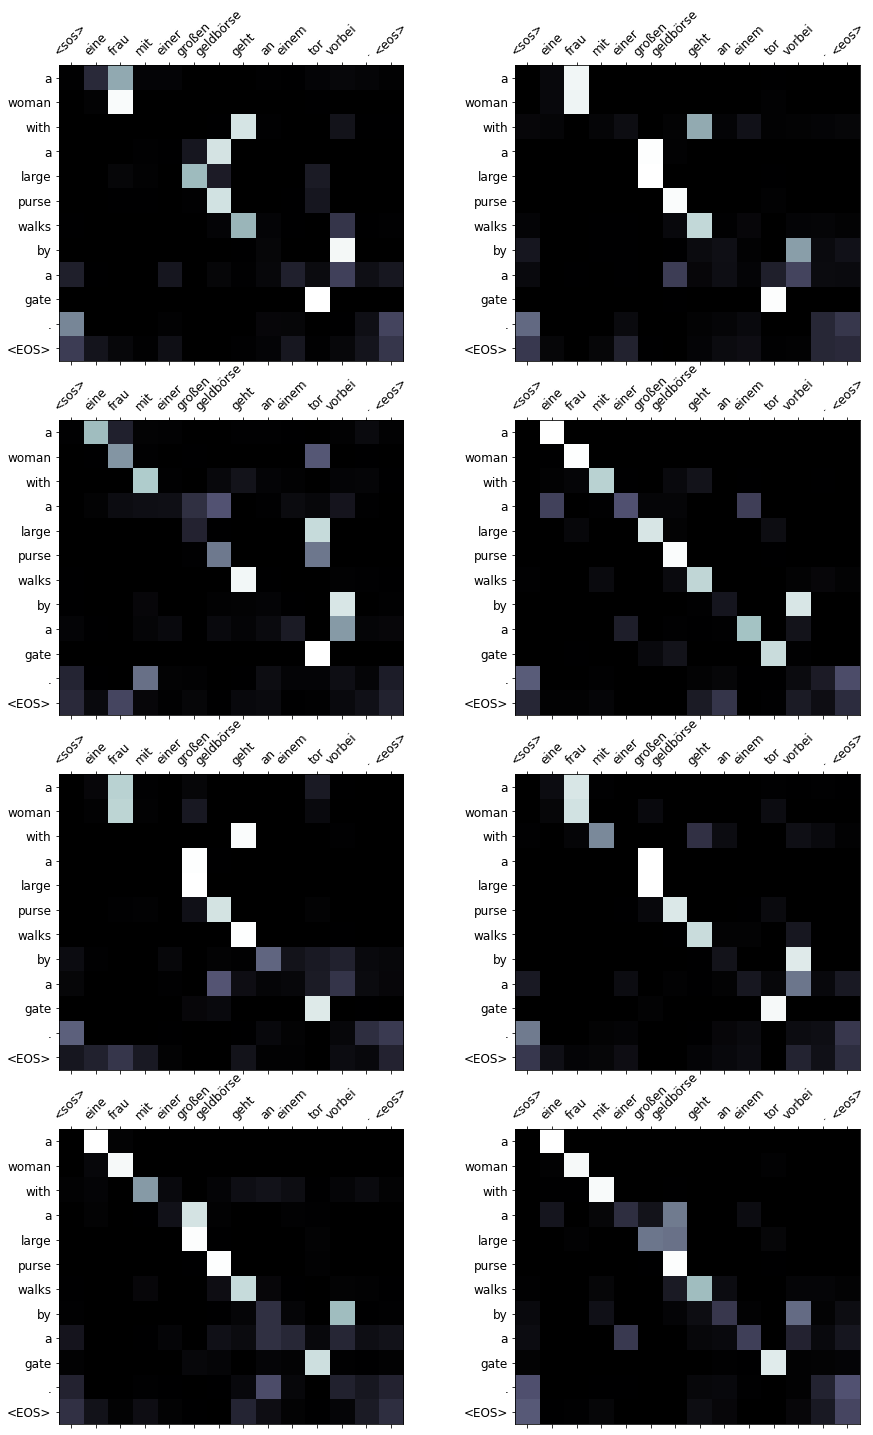

In [133]:
display_attention(src, translation, attention)

Next, let's get an example the model has not been trained on from the validation set.

In [134]:
example_idx = 6

src = validset[example_idx][0]
trg = validset[example_idx][1]

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


The model translates it by switching *is running* to just *runs*, but it is an acceptable swap.

In [135]:
translation, attention = translate_sentence(src, source_vocab, target_vocab, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.', '<EOS>']


Again, some heads pay full attention to "ein" whilst some pay no attention to it. Again, most of the heads seem to spread their attention over both the period and `<eos>` tokens in the source sentence when outputting the period and `<eos>` sentence in the predicted target sentence, though some seem to pay attention to tokens from near the start of the sentence.

/tmp/ipykernel_6267/1194617511.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45)
/tmp/ipykernel_6267/1194617511.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


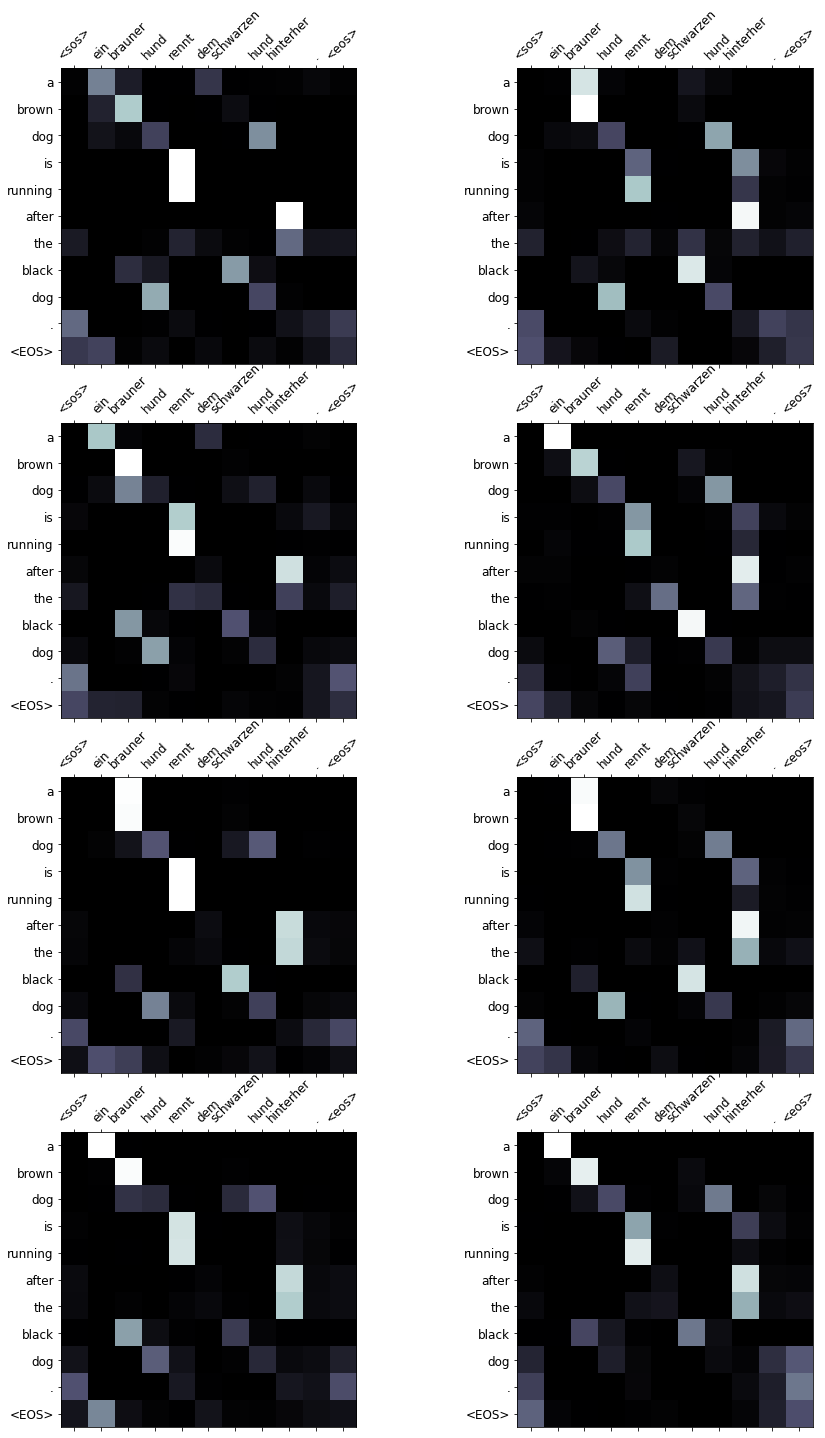

In [136]:
display_attention(src, translation, attention)

Finally, we'll look at an example from the test data.

In [137]:
example_idx = 10

src = testset[example_idx][0]
trg = testset[example_idx][1]

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'i', 'm', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


A perfect translation!

In [138]:
translation, attention = translate_sentence(src, source_vocab, target_vocab, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'young', 'mother', 'and', 'son', 'are', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<EOS>']


/tmp/ipykernel_6267/1194617511.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45)
/tmp/ipykernel_6267/1194617511.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


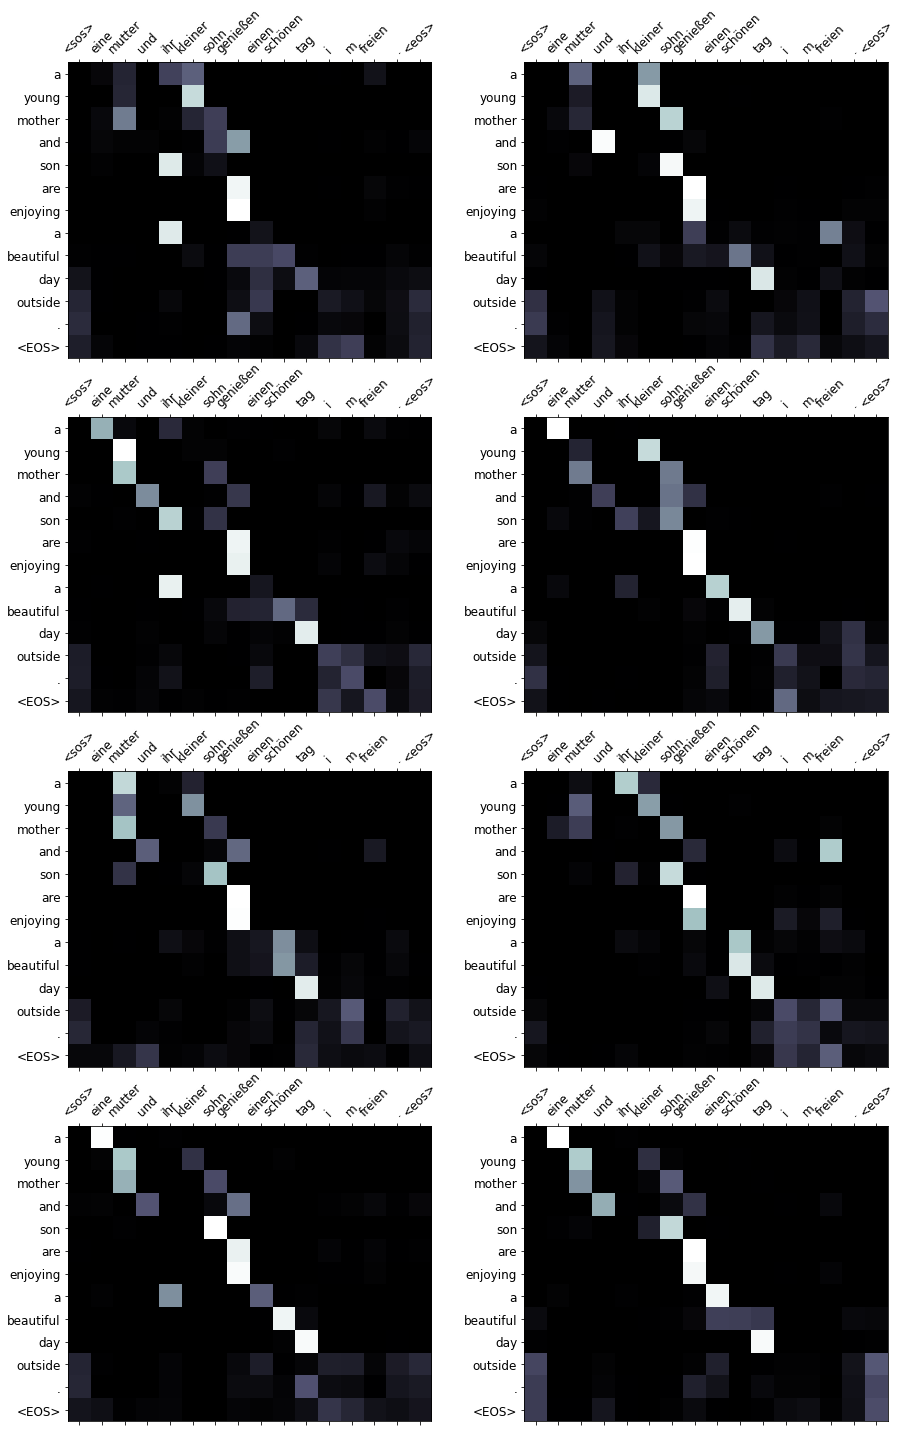

In [139]:
display_attention(src, translation, attention)

## BLEU

Finally we calculate the BLEU score for the Transformer.

In [166]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    i=0
    
    for datum in data:
        
        src = datum[0]
        trg = datum[1]
       
        
        pred_trg, _ = translate_sentence(src, source_vocab, target_vocab, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
       
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
    
        
    return bleu_score(pred_trgs, trgs)

We get a BLEU score of 36.52, which beats the ~34 of the convolutional sequence-to-sequence model and ~28 of the attention based RNN model. All this whilst having the least amount of parameters and the fastest training time!

In [167]:
bleu_score = calculate_bleu(testset, source_vocab, target_vocab, model, device)

In [169]:
print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 34.55


Congratulations for finishing these tutorials! I hope you've found them useful.

If you find any mistakes or want to ask any questions about any of the code or explanations used, feel free to submit a GitHub issue and I will try to correct it ASAP.

## Appendix

The `calculate_bleu` function above is unoptimized. Below is a significantly faster, vectorized version of it that should be used if needed. Credit for the implementation goes to [@azadyasar](https://github.com/azadyasar).

In [75]:
def translate_sentence_vectorized(src_tensor, source_vocab, target_vocab, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[target_vocab['<BOS>']] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == target_vocab['<EOS>']:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == target_vocab['<EOS>']:
                break
            pred_sentence.append(target_vocab.get_itos()[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [76]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, source_vocab, target_vocab, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for src, trg in iterator:
            src = src.to(device)
            trg = trg.to(device)
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if (i == target_vocab['<EOS>']) or (i == target_vocab['<PAD>']):
                        break
                    tmp.append(target_vocab.get_itos()[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, source_vocab, target_vocab, model, device)
            pred_trgs += pred_trg
    return  bleu_score(pred_trgs, trgs)

In [77]:
calculate_bleu_alt(test_loader, source_vocab, target_vocab, model, device, max_len = 50)

0.3537411146926866